In [1]:
import ssbc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
p_class1 = 0.50
beta_params_class0 = (2,5)
beta_params_class1 = (5,2)

alpha_0 = 0.10
delta_0 = 0.10
alpha_1 = 0.10
delta_1 = 0.10

In [3]:
sampler = ssbc.simulation.BinaryClassifierSimulator(
    p_class1=p_class1, 
    beta_params_class0=beta_params_class0,
    beta_params_class1=beta_params_class1)

In [4]:
labels , probs = sampler.generate(100)
class_data = ssbc.split_by_class(labels=labels, probs=probs)

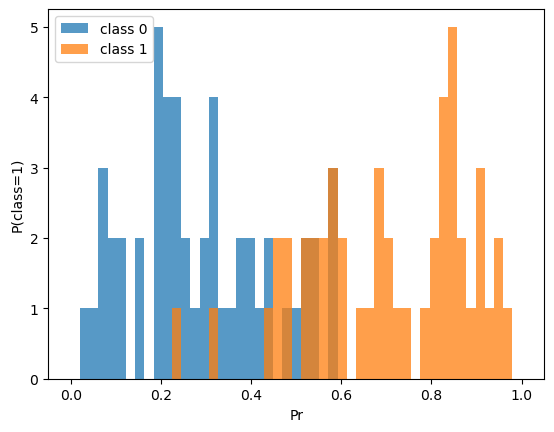

In [5]:
plt.hist(class_data[0]['probs'][:,1], bins=np.linspace(0,1,50), alpha=0.75)
plt.hist(class_data[1]['probs'][:,1], bins=np.linspace(0,1,50), alpha=0.75)
plt.legend(["class 0", "class 1"])
plt.ylabel('P(class=1)')
plt.xlabel("Pr")
plt.show()

In [6]:
# Validation with Corrected Simplified Bounds
import numpy as np
import matplotlib.pyplot as plt
from ssbc import BinaryClassifierSimulator, generate_rigorous_pac_report

# Generate report (now using SIMPLIFIED bounds)
report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,
    delta=0.10,
    test_size=100,
    ci_level=0.95,
    use_union_bound=True,
    n_jobs=-1,
    verbose=True
)

RIGOROUS PAC-CONTROLLED CONFORMAL PREDICTION REPORT

Parameters:
  Test size: 100
  CI level: 95% (Clopper-Pearson)
  PAC confidence: Class 0: 90%, Class 1: 90%, Marginal: 81%
  Union bound: YES (all metrics hold simultaneously)

CLASS 0 (Conditioned on True Label = 0)
  Calibration size: n = 51
  Target miscoverage: α = 0.100
  SSBC-corrected α:   α' = 0.0385
  PAC risk:           δ = 0.100
  Conformal threshold: 0.5801

  📊 Statistics from Calibration Data (n=51):
     [Basic CP CIs without PAC guarantee - evaluated on calibration data]
    Abstentions:         0 /   51 =  0.00%  95% CI: [0.000, 0.070]
    Singletons:         32 /   51 = 62.75%  95% CI: [0.481, 0.759]
      Correct:          31 /   51 = 60.78%  95% CI: [0.461, 0.742]
      Incorrect:         1 /   51 =  1.96%  95% CI: [0.000, 0.104]
    Error | singleton:     1 /   32 =  3.12%  95% CI: [0.001, 0.162]
    Doublets:           19 /   51 = 37.25%  95% CI: [0.241, 0.519]

  ✅ RIGOROUS PAC-Controlled Operational Bounds
   

Step 1: Generating calibration data and computing PAC bounds...
RIGOROUS PAC-CONTROLLED CONFORMAL PREDICTION REPORT

Parameters:
  Test size: 1000
  CI level: 95% (Clopper-Pearson)
  PAC confidence: Class 0: 90%, Class 1: 90%, Marginal: 81%
  Union bound: YES (all metrics hold simultaneously)

CLASS 0 (Conditioned on True Label = 0)
  Calibration size: n = 48
  Target miscoverage: α = 0.100
  SSBC-corrected α:   α' = 0.0408
  PAC risk:           δ = 0.100
  Conformal threshold: 0.6361

  📊 Statistics from Calibration Data (n=48):
     [Basic CP CIs without PAC guarantee - evaluated on calibration data]
    Abstentions:         0 /   48 =  0.00%  95% CI: [0.000, 0.074]
    Singletons:         40 /   48 = 83.33%  95% CI: [0.698, 0.925]
      Correct:          39 /   48 = 81.25%  95% CI: [0.674, 0.911]
      Incorrect:         1 /   48 =  2.08%  95% CI: [0.001, 0.111]
    Error | singleton:     1 /   40 =  2.50%  95% CI: [0.001, 0.132]
    Doublets:            8 /   48 = 16.67%  95% CI: [

/var/folders/sg/flwdvpwj6k1djjf0wn8f9q2w0000gn/T/ipykernel_76033/3054044224.py:431: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sg/flwdvpwj6k1djjf0wn8f9q2w0000gn/T/ipykernel_76033/3054044224.py:431: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sg/flwdvpwj6k1djjf0wn8f9q2w0000gn/T/ipykernel_76033/3054044224.py:473: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('pac_validation_final.png', dpi=300, bbox_inches='tight')
/var/folders/sg/flwdvpwj6k1djjf0wn8f9q2w0000gn/T/ipykernel_76033/3054044224.py:473: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('pac_validation_final.png', dpi=300, bbox_inches='tight')


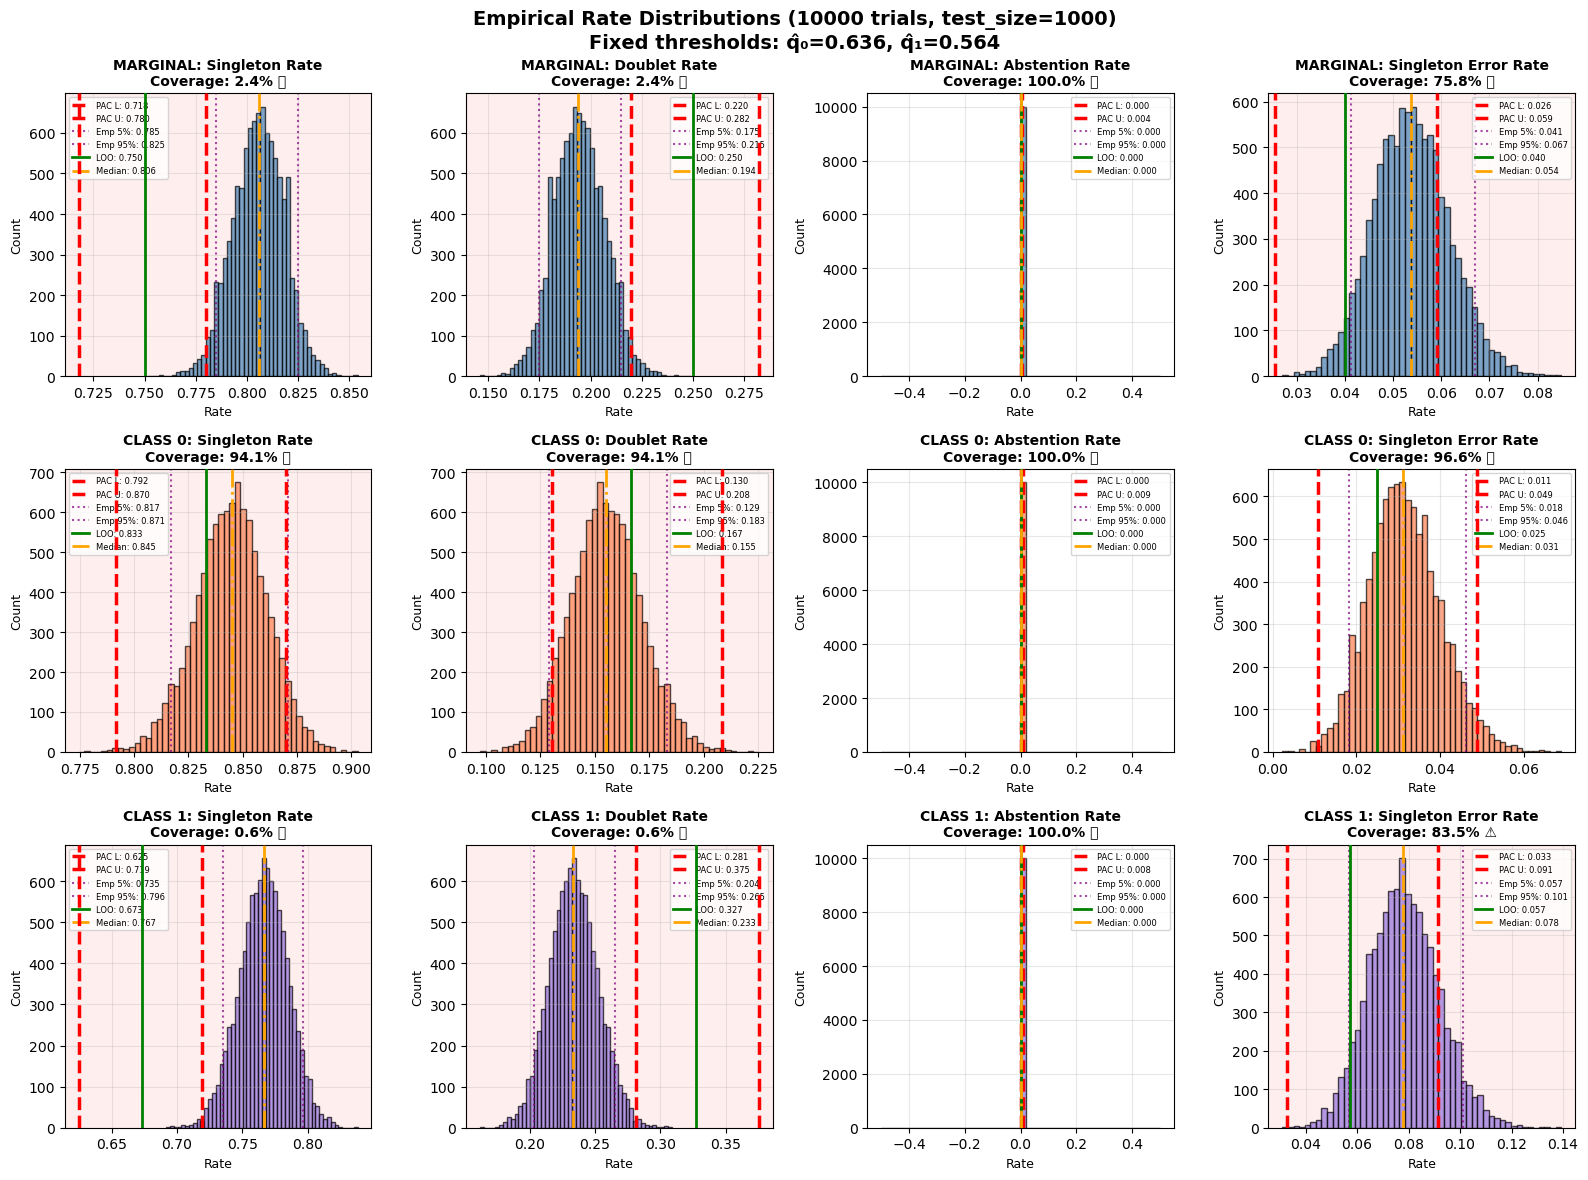


SUMMARY

✓ LOO-CV for unbiased rate estimates from calibration data
✓ CP intervals scaled to test_size (automatically wider for smaller n)
✓ Expected values (LOO-CV) should match empirical medians
✓ PAC bounds should contain ~95% of trials
✓ Empirical [5%, 95%] quantiles should be within PAC bounds


In [20]:
# ============================================================================
# EMPIRICAL VALIDATION OF PAC BOUNDS (WITH QUANTILES)
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from ssbc import BinaryClassifierSimulator, generate_rigorous_pac_report


def validate_pac_bounds(report, simulator, test_size, n_trials=1000, seed=None):
    """Validate PAC bounds by applying FIXED thresholds to many test sets.
    
    Parameters
    ----------
    report : dict
        Output from generate_rigorous_pac_report()
    simulator : BinaryClassifierSimulator
        Simulator to generate test data
    test_size : int
        Size of each test set
    n_trials : int, default=1000
        Number of independent trials
    seed : int, optional
        Random seed for reproducibility
        
    Returns
    -------
    dict
        Validation results with empirical coverage rates
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Extract FIXED thresholds from calibration
    threshold_0 = report['calibration_result'][0]['threshold']
    threshold_1 = report['calibration_result'][1]['threshold']
    
    print(f"Using fixed thresholds: q̂₀={threshold_0:.4f}, q̂₁={threshold_1:.4f}")
    print(f"Running {n_trials} trials with test_size={test_size}...")
    
    # Storage for realized rates
    marginal_singleton_rates = []
    marginal_doublet_rates = []
    marginal_abstention_rates = []
    marginal_singleton_error_rates = []
    
    class_0_singleton_rates = []
    class_0_doublet_rates = []
    class_0_abstention_rates = []
    class_0_singleton_error_rates = []
    
    class_1_singleton_rates = []
    class_1_doublet_rates = []
    class_1_abstention_rates = []
    class_1_singleton_error_rates = []
    
    # Run trials
    for _ in range(n_trials):
        # Generate independent test set
        labels_test, probs_test = simulator.generate(test_size)
        
        # Apply FIXED Mondrian thresholds and evaluate
        n_total = len(labels_test)
        n_singletons = 0
        n_doublets = 0
        n_abstentions = 0
        n_singletons_correct = 0
        
        # Per-class counters
        n_0 = np.sum(labels_test == 0)
        n_1 = np.sum(labels_test == 1)
        
        n_singletons_0 = 0
        n_doublets_0 = 0
        n_abstentions_0 = 0
        n_singletons_correct_0 = 0
        
        n_singletons_1 = 0
        n_doublets_1 = 0
        n_abstentions_1 = 0
        n_singletons_correct_1 = 0
        
        for i in range(n_total):
            true_label = labels_test[i]
            score_0 = 1.0 - probs_test[i, 0]
            score_1 = 1.0 - probs_test[i, 1]
            
            # Build prediction set using FIXED thresholds
            in_0 = score_0 <= threshold_0
            in_1 = score_1 <= threshold_1
            
            # Marginal counts
            if in_0 and in_1:
                n_doublets += 1
            elif in_0 or in_1:
                n_singletons += 1
                if (in_0 and true_label == 0) or (in_1 and true_label == 1):
                    n_singletons_correct += 1
            else:
                n_abstentions += 1
            
            # Per-class counts
            if true_label == 0:
                if in_0 and in_1:
                    n_doublets_0 += 1
                elif in_0 or in_1:
                    n_singletons_0 += 1
                    if in_0:
                        n_singletons_correct_0 += 1
                else:
                    n_abstentions_0 += 1
            else:  # true_label == 1
                if in_0 and in_1:
                    n_doublets_1 += 1
                elif in_0 or in_1:
                    n_singletons_1 += 1
                    if in_1:
                        n_singletons_correct_1 += 1
                else:
                    n_abstentions_1 += 1
        
        # Compute marginal rates
        marginal_singleton_rates.append(n_singletons / n_total)
        marginal_doublet_rates.append(n_doublets / n_total)
        marginal_abstention_rates.append(n_abstentions / n_total)
        
        singleton_error_rate = (
            (n_singletons - n_singletons_correct) / n_singletons
            if n_singletons > 0 else np.nan
        )
        marginal_singleton_error_rates.append(singleton_error_rate)
        
        # Compute per-class rates
        if n_0 > 0:
            class_0_singleton_rates.append(n_singletons_0 / n_0)
            class_0_doublet_rates.append(n_doublets_0 / n_0)
            class_0_abstention_rates.append(n_abstentions_0 / n_0)
            singleton_error_0 = (
                (n_singletons_0 - n_singletons_correct_0) / n_singletons_0
                if n_singletons_0 > 0 else np.nan
            )
            class_0_singleton_error_rates.append(singleton_error_0)
        
        if n_1 > 0:
            class_1_singleton_rates.append(n_singletons_1 / n_1)
            class_1_doublet_rates.append(n_doublets_1 / n_1)
            class_1_abstention_rates.append(n_abstentions_1 / n_1)
            singleton_error_1 = (
                (n_singletons_1 - n_singletons_correct_1) / n_singletons_1
                if n_singletons_1 > 0 else np.nan
            )
            class_1_singleton_error_rates.append(singleton_error_1)
    
    # Convert to arrays
    marginal_singleton_rates = np.array(marginal_singleton_rates)
    marginal_doublet_rates = np.array(marginal_doublet_rates)
    marginal_abstention_rates = np.array(marginal_abstention_rates)
    marginal_singleton_error_rates = np.array(marginal_singleton_error_rates)
    
    class_0_singleton_rates = np.array(class_0_singleton_rates)
    class_0_doublet_rates = np.array(class_0_doublet_rates)
    class_0_abstention_rates = np.array(class_0_abstention_rates)
    class_0_singleton_error_rates = np.array(class_0_singleton_error_rates)
    
    class_1_singleton_rates = np.array(class_1_singleton_rates)
    class_1_doublet_rates = np.array(class_1_doublet_rates)
    class_1_abstention_rates = np.array(class_1_abstention_rates)
    class_1_singleton_error_rates = np.array(class_1_singleton_error_rates)
    
    # Check coverage functions
    def check_coverage(rates, bounds):
        """Check what fraction of rates fall within bounds."""
        lower, upper = bounds
        within = np.sum((rates >= lower) & (rates <= upper))
        return within / len(rates)
    
    def check_coverage_with_nan(rates, bounds):
        """Check coverage, ignoring NaN values."""
        lower, upper = bounds
        valid = ~np.isnan(rates)
        if np.sum(valid) == 0:
            return np.nan
        rates_valid = rates[valid]
        within = np.sum((rates_valid >= lower) & (rates_valid <= upper))
        return within / len(rates_valid)
    
    def compute_quantiles(rates):
        """Compute quantiles, handling NaN."""
        valid = rates[~np.isnan(rates)] if np.any(np.isnan(rates)) else rates
        if len(valid) == 0:
            return {'q05': np.nan, 'q25': np.nan, 'q50': np.nan, 'q75': np.nan, 'q95': np.nan}
        return {
            'q05': np.percentile(valid, 5),
            'q25': np.percentile(valid, 25),
            'q50': np.percentile(valid, 50),
            'q75': np.percentile(valid, 75),
            'q95': np.percentile(valid, 95),
        }
    
    # Get bounds from report
    pac_marg = report['pac_bounds_marginal']
    pac_0 = report['pac_bounds_class_0']
    pac_1 = report['pac_bounds_class_1']
    
    return {
        'n_trials': n_trials,
        'test_size': test_size,
        'threshold_0': threshold_0,
        'threshold_1': threshold_1,
        'marginal': {
            'singleton': {
                'rates': marginal_singleton_rates,
                'mean': np.mean(marginal_singleton_rates),
                'quantiles': compute_quantiles(marginal_singleton_rates),
                'bounds': pac_marg['singleton_rate_bounds'],
                'expected': pac_marg['expected_singleton_rate'],
                'empirical_coverage': check_coverage(marginal_singleton_rates, pac_marg['singleton_rate_bounds']),
            },
            'doublet': {
                'rates': marginal_doublet_rates,
                'mean': np.mean(marginal_doublet_rates),
                'quantiles': compute_quantiles(marginal_doublet_rates),
                'bounds': pac_marg['doublet_rate_bounds'],
                'expected': pac_marg['expected_doublet_rate'],
                'empirical_coverage': check_coverage(marginal_doublet_rates, pac_marg['doublet_rate_bounds']),
            },
            'abstention': {
                'rates': marginal_abstention_rates,
                'mean': np.mean(marginal_abstention_rates),
                'quantiles': compute_quantiles(marginal_abstention_rates),
                'bounds': pac_marg['abstention_rate_bounds'],
                'expected': pac_marg['expected_abstention_rate'],
                'empirical_coverage': check_coverage(marginal_abstention_rates, pac_marg['abstention_rate_bounds']),
            },
            'singleton_error': {
                'rates': marginal_singleton_error_rates,
                'mean': np.nanmean(marginal_singleton_error_rates),
                'quantiles': compute_quantiles(marginal_singleton_error_rates),
                'bounds': pac_marg['singleton_error_rate_bounds'],
                'expected': pac_marg['expected_singleton_error_rate'],
                'empirical_coverage': check_coverage_with_nan(marginal_singleton_error_rates, pac_marg['singleton_error_rate_bounds']),
            },
        },
        'class_0': {
            'singleton': {
                'rates': class_0_singleton_rates,
                'mean': np.mean(class_0_singleton_rates),
                'quantiles': compute_quantiles(class_0_singleton_rates),
                'bounds': pac_0['singleton_rate_bounds'],
                'expected': pac_0['expected_singleton_rate'],
                'empirical_coverage': check_coverage(class_0_singleton_rates, pac_0['singleton_rate_bounds']),
            },
            'doublet': {
                'rates': class_0_doublet_rates,
                'mean': np.mean(class_0_doublet_rates),
                'quantiles': compute_quantiles(class_0_doublet_rates),
                'bounds': pac_0['doublet_rate_bounds'],
                'expected': pac_0['expected_doublet_rate'],
                'empirical_coverage': check_coverage(class_0_doublet_rates, pac_0['doublet_rate_bounds']),
            },
            'abstention': {
                'rates': class_0_abstention_rates,
                'mean': np.mean(class_0_abstention_rates),
                'quantiles': compute_quantiles(class_0_abstention_rates),
                'bounds': pac_0['abstention_rate_bounds'],
                'expected': pac_0['expected_abstention_rate'],
                'empirical_coverage': check_coverage(class_0_abstention_rates, pac_0['abstention_rate_bounds']),
            },
            'singleton_error': {
                'rates': class_0_singleton_error_rates,
                'mean': np.nanmean(class_0_singleton_error_rates),
                'quantiles': compute_quantiles(class_0_singleton_error_rates),
                'bounds': pac_0['singleton_error_rate_bounds'],
                'expected': pac_0['expected_singleton_error_rate'],
                'empirical_coverage': check_coverage_with_nan(class_0_singleton_error_rates, pac_0['singleton_error_rate_bounds']),
            },
        },
        'class_1': {
            'singleton': {
                'rates': class_1_singleton_rates,
                'mean': np.mean(class_1_singleton_rates),
                'quantiles': compute_quantiles(class_1_singleton_rates),
                'bounds': pac_1['singleton_rate_bounds'],
                'expected': pac_1['expected_singleton_rate'],
                'empirical_coverage': check_coverage(class_1_singleton_rates, pac_1['singleton_rate_bounds']),
            },
            'doublet': {
                'rates': class_1_doublet_rates,
                'mean': np.mean(class_1_doublet_rates),
                'quantiles': compute_quantiles(class_1_doublet_rates),
                'bounds': pac_1['doublet_rate_bounds'],
                'expected': pac_1['expected_doublet_rate'],
                'empirical_coverage': check_coverage(class_1_doublet_rates, pac_1['doublet_rate_bounds']),
            },
            'abstention': {
                'rates': class_1_abstention_rates,
                'mean': np.mean(class_1_abstention_rates),
                'quantiles': compute_quantiles(class_1_abstention_rates),
                'bounds': pac_1['abstention_rate_bounds'],
                'expected': pac_1['expected_abstention_rate'],
                'empirical_coverage': check_coverage(class_1_abstention_rates, pac_1['abstention_rate_bounds']),
            },
            'singleton_error': {
                'rates': class_1_singleton_error_rates,
                'mean': np.nanmean(class_1_singleton_error_rates),
                'quantiles': compute_quantiles(class_1_singleton_error_rates),
                'bounds': pac_1['singleton_error_rate_bounds'],
                'expected': pac_1['expected_singleton_error_rate'],
                'empirical_coverage': check_coverage_with_nan(class_1_singleton_error_rates, pac_1['singleton_error_rate_bounds']),
            },
        },
    }


def print_validation_results(validation):
    """Pretty print validation results with quantiles."""
    print("\n" + "="*80)
    print(f"EMPIRICAL VALIDATION RESULTS")
    print(f"({validation['n_trials']} trials, test_size={validation['test_size']})")
    print("="*80)
    
    print(f"\nFixed thresholds: q̂₀={validation['threshold_0']:.4f}, q̂₁={validation['threshold_1']:.4f}")
    
    # Marginal results
    print("\n" + "-"*80)
    print("MARGINAL (All Samples)")
    print("-"*80)
    for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
        m = validation['marginal'][metric]
        lower, upper = m['bounds']
        mean = m['mean']
        q = m['quantiles']
        cov = m['empirical_coverage']
        exp = m['expected']
        
        status = "✅" if cov >= 0.90 else ("⚠️" if cov >= 0.80 else "❌")
        
        print(f"\n{metric.upper().replace('_', ' ')}:")
        print(f"  Empirical mean: {mean:.4f}")
        print(f"  Expected (LOO): {exp:.4f}")
        print(f"  Quantiles:      [5%: {q['q05']:.3f}, 25%: {q['q25']:.3f}, 50%: {q['q50']:.3f}, 75%: {q['q75']:.3f}, 95%: {q['q95']:.3f}]")
        print(f"  PAC bounds:     [{lower:.4f}, {upper:.4f}]")
        print(f"  Coverage:       {cov:.1%} {status}")
    
    # Per-class results
    for class_label in [0, 1]:
        print("\n" + "-"*80)
        print(f"CLASS {class_label}")
        print("-"*80)
        for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
            m = validation[f'class_{class_label}'][metric]
            lower, upper = m['bounds']
            mean = m['mean']
            q = m['quantiles']
            cov = m['empirical_coverage']
            exp = m['expected']
            
            status = "✅" if cov >= 0.90 else ("⚠️" if cov >= 0.80 else "❌")
            
            print(f"\n{metric.upper().replace('_', ' ')}:")
            print(f"  Empirical mean: {mean:.4f}")
            print(f"  Expected (LOO): {exp:.4f}")
            print(f"  Quantiles:      [5%: {q['q05']:.3f}, 25%: {q['q25']:.3f}, 50%: {q['q50']:.3f}, 75%: {q['q75']:.3f}, 95%: {q['q95']:.3f}]")
            print(f"  PAC bounds:     [{lower:.4f}, {upper:.4f}]")
            print(f"  Coverage:       {cov:.1%} {status}")
    
    print("\n" + "="*80)


def plot_validation_histograms(validation, figsize=(16, 12)):
    """Create histograms for all simulated rates with PAC bounds."""
    fig, axes = plt.subplots(3, 4, figsize=figsize)
    fig.suptitle(
        f'Empirical Rate Distributions ({validation["n_trials"]} trials, test_size={validation["test_size"]})\n'
        f'Fixed thresholds: q̂₀={validation["threshold_0"]:.3f}, q̂₁={validation["threshold_1"]:.3f}',
        fontsize=14, fontweight='bold'
    )
    
    metrics = ['singleton', 'doublet', 'abstention', 'singleton_error']
    metric_names = ['Singleton Rate', 'Doublet Rate', 'Abstention Rate', 'Singleton Error Rate']
    colors = ['steelblue', 'coral', 'mediumpurple']
    row_names = ['MARGINAL', 'CLASS 0', 'CLASS 1']
    data_keys = ['marginal', 'class_0', 'class_1']
    
    for row, (row_name, data_key, color) in enumerate(zip(row_names, data_keys, colors)):
        for col, (metric, name) in enumerate(zip(metrics, metric_names)):
            ax = axes[row, col]
            m = validation[data_key][metric]
            
            # Filter out NaNs
            rates = m['rates']
            if metric == 'singleton_error':
                rates = rates[~np.isnan(rates)]
            
            if len(rates) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
                continue
            
            # Histogram
            ax.hist(rates, bins=50, alpha=0.7, color=color, edgecolor='black', density=False)
            
            # PAC bounds
            lower, upper = m['bounds']
            ax.axvline(lower, color='red', linestyle='--', linewidth=2.5, label=f'PAC L: {lower:.3f}', zorder=10)
            ax.axvline(upper, color='red', linestyle='--', linewidth=2.5, label=f'PAC U: {upper:.3f}', zorder=10)
            
            # Empirical quantiles (5%, 95%)
            q = m['quantiles']
            ax.axvline(q['q05'], color='purple', linestyle=':', linewidth=1.5, label=f'Emp 5%: {q["q05"]:.3f}', alpha=0.7)
            ax.axvline(q['q95'], color='purple', linestyle=':', linewidth=1.5, label=f'Emp 95%: {q["q95"]:.3f}', alpha=0.7)
            
            # Expected value (from LOO-CV)
            ax.axvline(m['expected'], color='green', linestyle='-', linewidth=2, label=f'LOO: {m["expected"]:.3f}', zorder=10)
            
            # Empirical median
            ax.axvline(q['q50'], color='orange', linestyle='-.', linewidth=2, label=f'Median: {q["q50"]:.3f}', zorder=10)
            
            # Coverage
            coverage = m['empirical_coverage']
            status = "✅" if coverage >= 0.90 else ("⚠️" if coverage >= 0.80 else "❌")
            ax.set_title(f'{row_name}: {name}\nCoverage: {coverage:.1%} {status}', fontweight='bold', fontsize=10)
            ax.set_xlabel('Rate', fontsize=9)
            ax.set_ylabel('Count', fontsize=9)
            ax.legend(loc='best', fontsize=6)
            ax.grid(True, alpha=0.3)
            
            # Highlight if PAC bounds don't contain empirical 5-95% range
            if q['q05'] < lower or q['q95'] > upper:
                ax.set_facecolor('#ffeeee')
    
    plt.tight_layout()
    return fig


# ============================================================================
# COMPLETE VALIDATION WORKFLOW
# ============================================================================

# Step 1: Generate calibration data and compute PAC bounds
print("Step 1: Generating calibration data and computing PAC bounds...")

labels, probs = sampler.generate(100)
report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,
    delta=0.10,
    test_size=1000,  # Test sets will be smaller than calibration
    ci_level=0.95,
    use_union_bound=True,
    n_jobs=-1,
    verbose=True
)

# Step 2: Validate with 10000 independent test sets
print("\n\n" + "="*80)
print("Step 2: Running empirical validation...")
print("="*80)

validation = validate_pac_bounds(
    report=report,
    simulator=sampler,
    test_size=1000,
    n_trials=10000,
)

# Step 3: Print validation results with quantiles
print_validation_results(validation)

# Step 4: Plot histograms
print("\n\nStep 3: Creating histogram visualizations...")
fig = plot_validation_histograms(validation)
plt.savefig('pac_validation_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 5: Summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print("\n✓ LOO-CV for unbiased rate estimates from calibration data")
print("✓ CP intervals scaled to test_size (automatically wider for smaller n)")
print("✓ Expected values (LOO-CV) should match empirical medians")
print("✓ PAC bounds should contain ~95% of trials")
print(f"✓ Empirical [5%, 95%] quantiles should be within PAC bounds")
print("="*80)